In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Imports and Global Variables

In [2]:
import nltk
from nltk.corpus import words
from PIL import Image, ImageDraw, ImageFont
from PIL import Image
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

max_word_size = 10
image_dir = '/content/drive/MyDrive/smai_a5/word_images_10k'

## Creating Dataset and splitting function

In [3]:
def split_into_train_test_val(labels, train_size=0.8, test_size=0.2, val_size=None, seed=None):
    # Calculate the validation size if not provided
    if val_size is None:
        val_size = 1.0 - train_size - test_size
        if val_size < 0.0:
            raise ValueError("Sum of train and test sizes exceeds 1.0")

    # Check if the sizes sum up to 1.0 (or 100%)
    if not (train_size + test_size + val_size == 1.0):
        raise ValueError("Train, test, and validation sizes must sum up to 1.0.")

    # Set the random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Get the total number of samples
    n_samples = len(labels)

    # Create a shuffled array of indices
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    # Compute split points
    train_end = int(n_samples * train_size)
    test_end = train_end + int(n_samples * test_size)

    # Split indices into training, testing, and validation based on the sizes
    train_indices = indices[:train_end]
    test_indices = indices[train_end:test_end]
    val_indices = indices[test_end:]

    # Split labels into training, testing, and validation sets
    train_labels = [labels[i] for i in train_indices]
    test_labels = [labels[i] for i in test_indices]
    val_labels = [labels[i] for i in val_indices]

    return train_labels, test_labels, val_labels

def generate_dataset(output_dir, font_path, max_word_size=256, n_words=10_000):
    nltk.download('words') # Download the list of words
    word_list = words.words() # Get the list of words
    word_list = [word.lower() for word in word_list if len(word) <= max_word_size]

    # Randomly sample words
    random.shuffle(word_list)
    word_list = word_list[:n_words]

    font_size = 24  # Adjust font size as needed
    font = ImageFont.truetype(font_path, font_size)

    # Create images
    for i, word in enumerate(word_list):
        # Create a blank white image
        img = Image.new('RGB', (256, 64), color='white')
        draw = ImageDraw.Draw(img)

        # Get text bounding box and calculate the text size
        text_bbox = draw.textbbox((0, 0), word, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Center the text
        position = ((256 - text_width) // 2, (64 - text_height) // 2)

        # Render the word onto the image
        draw.text(position, word, font=font, fill='black')

        # Save the image
        img.save(output_dir + f"/{i}_{word}.png")

        if i % 1000 == 0 and i != 0:
            print(f'Generated {i} images...')

    print('Dataset generation complete.')

In [4]:
# Run this for the first time if the dataset is not already created
# n_words = 10_000
# generate_dataset(image_dir, '/content/drive/MyDrive/smai_a5/DejaVuSans-Bold.ttf', max_word_size, n_words)

## Function to plot train and val loss graphs and Avg correct characters predicted

In [5]:
def plot_loss_graph(train_loss_arr, val_loss_arr, train_correct_arr, val_correct_arr):
    epochs = range(1, len(train_loss_arr) + 1)

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot training and validation losses on the first subplot
    axes[0].plot(epochs, train_loss_arr, color='darkorange', linestyle='-', marker='o', label='Training Loss', linewidth=2.5)
    axes[0].plot(epochs, val_loss_arr, color='teal', linestyle='--', marker='s', label='Validation Loss', linewidth=2.5)
    axes[0].fill_between(epochs, train_loss_arr, val_loss_arr, color='lightgray', alpha=0.3)
    axes[0].set_title('Training and Validation Loss over Epochs', fontsize=16, pad=20, fontweight='bold')
    axes[0].set_xlabel('Epochs', fontsize=13)
    axes[0].set_ylabel('Loss (MSE)', fontsize=13)
    axes[0].grid(True, linestyle='-.', color='lightgray', alpha=0.6)
    axes[0].minorticks_on()
    axes[0].grid(True, which='minor', linestyle=':', color='lightgray', alpha=0.3)
    axes[0].legend(loc='upper right', fontsize=12)
    axes[0].tick_params(axis='both', labelsize=11)

    # Plot average correct values on the second subplot
    axes[1].plot(epochs, train_correct_arr, color='purple', linestyle='-', marker='d', label='Avg Train Correct', linewidth=2.5)
    axes[1].plot(epochs, val_correct_arr, color='yellow', linestyle='--', marker='^', label='Avg Val Correct', linewidth=2.5)
    axes[1].set_title('Training and Validation Avg Correct over Epochs', fontsize=16, pad=20, fontweight='bold')
    axes[1].set_xlabel('Epochs', fontsize=13)
    axes[1].set_ylabel('Avg Correct Chars', fontsize=13)
    axes[1].grid(True, linestyle='-.', color='lightgray', alpha=0.6)
    axes[1].minorticks_on()
    axes[1].grid(True, which='minor', linestyle=':', color='lightgray', alpha=0.3)
    axes[1].legend(loc='upper right', fontsize=12)
    axes[1].tick_params(axis='both', labelsize=11)

    plt.tight_layout()
    plt.show()

## Image Dataset Class

In [6]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, image_names_list, transform=None):
        self.transform = transform
        self.image_dir = image_dir
        self.image_names_list = image_names_list

    def __len__(self):
        return len(self.image_names_list)

    def __getitem__(self, idx):
        img_name = self.image_names_list[idx]
        img_path = image_dir + "/" + img_name

        # Extract label from the filename, assuming filename format is "idx_name.png"
        label = img_name.split('_')[1].split('.')[0]  # Extract 'name' part after the '_'

        # Open the image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            image = self.transform(image)

        # Convert label (string) to tensor (e.g., list of character indices)
        label_tensor = torch.tensor([ord(ch) for ch in label], dtype=torch.long)  # Example: converting label to indices

        return image, label_tensor

def function_to_collate(batch):
    images, labels = zip(*batch)

    # Stack images in a batch (assuming they are already transformed into tensors)
    images = torch.stack(images, dim=0)

    # Find the max length of the labels in this batch
    max_label_length = max_word_size

    # Pad labels to the same length
    padded_labels = []
    for label in labels:
        # Pad each label to the max length with a padding value (e.g., 0)
        padding = max_label_length - label.size(0)
        padded_label = F.pad(label, (0, padding), value=0)  # Pad the sequence on the right side
        padded_labels.append(padded_label)

    # Stack labels into a tensor (all labels in the batch now have the same length)
    padded_labels = torch.stack(padded_labels, dim=0)

    return images, padded_labels


## OCR Class

In [7]:
class OCRModel(nn.Module):
    def __init__(self, input_channels, hidden_size, num_layers, output_size, dropout=0.2):
        super(OCRModel, self).__init__()

        # CNN Encoder: Extract spatial features
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # RNN Decoder: Sequentially predict each character
        self.rnn = nn.RNN(input_size=128 * 16 * 64, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # Apply CNN to extract features
        cnn_out = self.cnn(x)
        batch_size, channels, height, width = cnn_out.size()
        cnn_out = cnn_out.view(batch_size, channels * height * width)  # Flatten the output

        # Add a batch dimension (because the RNN expects input with shape (batch, seq_len, input_size))
        cnn_out = cnn_out.unsqueeze(1)  # Make it (batch_size, seq_len=1, features)

        # Apply RNN
        rnn_out, _ = self.rnn(cnn_out)
        rnn_out = rnn_out[:, -1, :]
        output = self.fc(rnn_out)

        return output

    def load_data(self, image_dir, train_image_names, val_image_names, batch_size=32):
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converts image to Tensor and normalizes to [0, 1]
        ])

        train_dataset = ImageDataset(image_dir=image_dir, image_names_list=train_image_names, transform=self.transform)
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=function_to_collate)

        val_dataset = ImageDataset(image_dir=image_dir, image_names_list=val_image_names, transform=self.transform)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=function_to_collate)

    def train_model(self, criterion="MSE", optimiser="Adam", num_epochs=20, lr=0.001, device="cpu"):
        if criterion.lower() == "mse":
            self.criterion = nn.MSELoss()
        elif criterion.lower() == "crossentropy":
            self.criterion = nn.CrossEntropyLoss()
        elif criterion.lower() == "mae":
            self.criterion = nn.L1Loss()
        else:
            raise ValueError(f"Invalid criterion: {criterion} - choose from 'mse', 'mae' or 'crossentropy'")

        if optimiser.lower() == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimiser.lower() == "sgd":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        else:
            raise ValueError(f"Invalid optimiser: {optimiser} - Choose from 'adam' or 'sgd'")

        train_loss_arr = []
        val_loss_arr = []
        correct_chars_train_loss_arr = []
        correct_chars_val_loss_arr = []

        for epoch in range(num_epochs):
            self.train()
            train_loss = 0
            total_train_correct = 0

            # k = 0
            for images, labels in self.train_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                output = self.forward(images)  # Output shape: (batch_size, seq_len, output_size)

                # Compute the loss (considering each character in the sequence)
                self.optimizer.zero_grad()
                loss = self.criterion(output.view(-1).to(torch.float32), labels.view(-1).to(torch.float32))  # Flattened output and labels
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

                for i in range(len(output)):
                    for j in range(len(output[i])):
                        if int(output[i][j]) == labels[i][j]:
                            total_train_correct += 1

                # print(f"iter {k}, epoch {epoch} done")
                # k += 1

            avg_train_correct = total_train_correct / (len(self.train_loader) * self.batch_size)
            correct_chars_train_loss_arr.append(avg_train_correct)

            avg_train_loss = train_loss / len(self.train_loader)
            train_loss_arr.append(avg_train_loss)

            self.eval()
            val_loss = 0
            total_val_correct = 0

            with torch.no_grad():
                for images, labels in self.val_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    output = self.forward(images)
                    loss = self.criterion(output.view(-1).to(torch.float32), labels.view(-1).to(torch.float32))
                    val_loss += loss.item()

                    for i in range(len(output)):
                        for j in range(len(output[i])):
                            if int(output[i][j]) == labels[i][j]:
                                total_val_correct += 1

            avg_val_correct = total_val_correct / (len(self.val_loader) * self.batch_size)
            correct_chars_val_loss_arr.append(avg_val_correct)

            avg_val_loss = val_loss / len(self.val_loader)
            val_loss_arr.append(avg_val_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss (MSE): {avg_train_loss:.4f}, Val Loss (MSE): {avg_val_loss:.4f}, Avg Train Correct: {avg_train_correct:.4f}, Avg Val Correct: {avg_val_correct:.4f}")

        return train_loss_arr, val_loss_arr, correct_chars_train_loss_arr, correct_chars_val_loss_arr

    def get_loss(self, image_dir, test_image_names):
        test_dataset = ImageDataset(image_dir=image_dir, image_names_list=test_image_names, transform=self.transform)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, collate_fn=function_to_collate)

        self.eval()
        test_loss = 0
        total_test_correct = 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                output = self.forward(images)
                loss = self.criterion(output.view(-1).to(torch.float32), labels.view(-1).to(torch.float32))
                test_loss += loss.item()

                for i in range(len(output)):
                    for j in range(len(output[i])):
                        if int(output[i][j]) == labels[i][j]:
                            total_test_correct += 1

        avg_test_correct = total_test_correct / (len(self.test_loader) * self.batch_size)
        avg_test_loss = test_loss / len(self.test_loader)
        return avg_test_loss, avg_test_correct


## Selecting Device

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Splitting Data

In [9]:
image_names = os.listdir(image_dir)

train_image_names,  test_image_names, val_image_names = split_into_train_test_val(image_names, train_size=0.7, test_size=0.15, val_size=0.15)
print("Data read and split into train, test and val set")


Data read and split into train, test and val set


## Hyperparameters

In [10]:
# Hyperparameters
hyperparams1 = {
    'input_channels': 1,
    'hidden_size': 128,
    'num_layers': 2,
    'output_size': max_word_size,
    'dropout': 0.2,
    'batch_size': 32,
    'num_epochs': 10,
    'lr': 0.001
}

hyperparams2 = {
    'input_channels': 1,
    'hidden_size': 64,
    'num_layers': 3,
    'output_size': max_word_size,
    'dropout': 0.2,
    'batch_size': 32,
    'num_epochs': 10,
    'lr': 0.001
}

hyperparams3 = {
    'input_channels': 1,
    'hidden_size': 128,
    'num_layers': 3,
    'output_size': max_word_size,
    'dropout': 0.2,
    'batch_size': 32,
    'num_epochs': 10,
    'lr': 0.1
}

hyperparams4 = {
    'input_channels': 1,
    'hidden_size': 256,
    'num_layers': 1,
    'output_size': max_word_size,
    'dropout': 0.2,
    'batch_size': 32,
    'num_epochs': 10,
    'lr': 0.001
}

hyperparams5 = {
    'input_channels': 1,
    'hidden_size': 128,
    'num_layers': 5,
    'output_size': max_word_size,
    'dropout': 0.2,
    'batch_size': 32,
    'num_epochs': 10,
    'lr': 0.001
}

## Training models

### Model 1

In [11]:
# Initialize the model
model1 = OCRModel(input_channels=hyperparams1["input_channels"], hidden_size=hyperparams1["hidden_size"], num_layers=hyperparams1["num_layers"], output_size=hyperparams1["output_size"], dropout=hyperparams1["dropout"])
model1.to(device)
model1.load_data(image_dir, train_image_names, val_image_names, hyperparams1["batch_size"])
print("Data loaded")

# Train the model
train_loss_arr1, val_loss_arr1, train_correct_arr1, val_correct_arr1 = model1.train_model(criterion="mse", optimiser="Adam", num_epochs=hyperparams1["num_epochs"], lr=hyperparams1["lr"], device=device)

# Testing the model
test_loss1, test_correct1 = model1.get_loss(image_dir, test_image_names)
print(f"Test Loss (MSE): {test_loss1:.4f}, Avg Test Correct: {test_correct1:.4f}")

Data loaded
Epoch 1/10, Train Loss (MSE): 8228.8548, Val Loss (MSE): 6386.2607, Avg Train Correct: 0.9096, Avg Val Correct: 0.0000
Epoch 2/10, Train Loss (MSE): 4143.5815, Val Loss (MSE): 1972.3373, Avg Train Correct: 0.0000, Avg Val Correct: 0.0000
Epoch 3/10, Train Loss (MSE): 1431.2787, Val Loss (MSE): 1157.3477, Avg Train Correct: 0.0639, Avg Val Correct: 0.0813
Epoch 4/10, Train Loss (MSE): 1280.8940, Val Loss (MSE): 1143.8065, Avg Train Correct: 0.1889, Avg Val Correct: 0.2437
Epoch 5/10, Train Loss (MSE): 1237.2256, Val Loss (MSE): 1142.2856, Avg Train Correct: 0.1692, Avg Val Correct: 0.2437
Epoch 6/10, Train Loss (MSE): 1235.0190, Val Loss (MSE): 1142.7586, Avg Train Correct: 0.1868, Avg Val Correct: 0.2437
Epoch 7/10, Train Loss (MSE): 1243.5697, Val Loss (MSE): 1144.1309, Avg Train Correct: 0.1590, Avg Val Correct: 0.1719
Epoch 8/10, Train Loss (MSE): 1227.1982, Val Loss (MSE): 1140.8112, Avg Train Correct: 0.1848, Avg Val Correct: 0.1125
Epoch 9/10, Train Loss (MSE): 1228.5

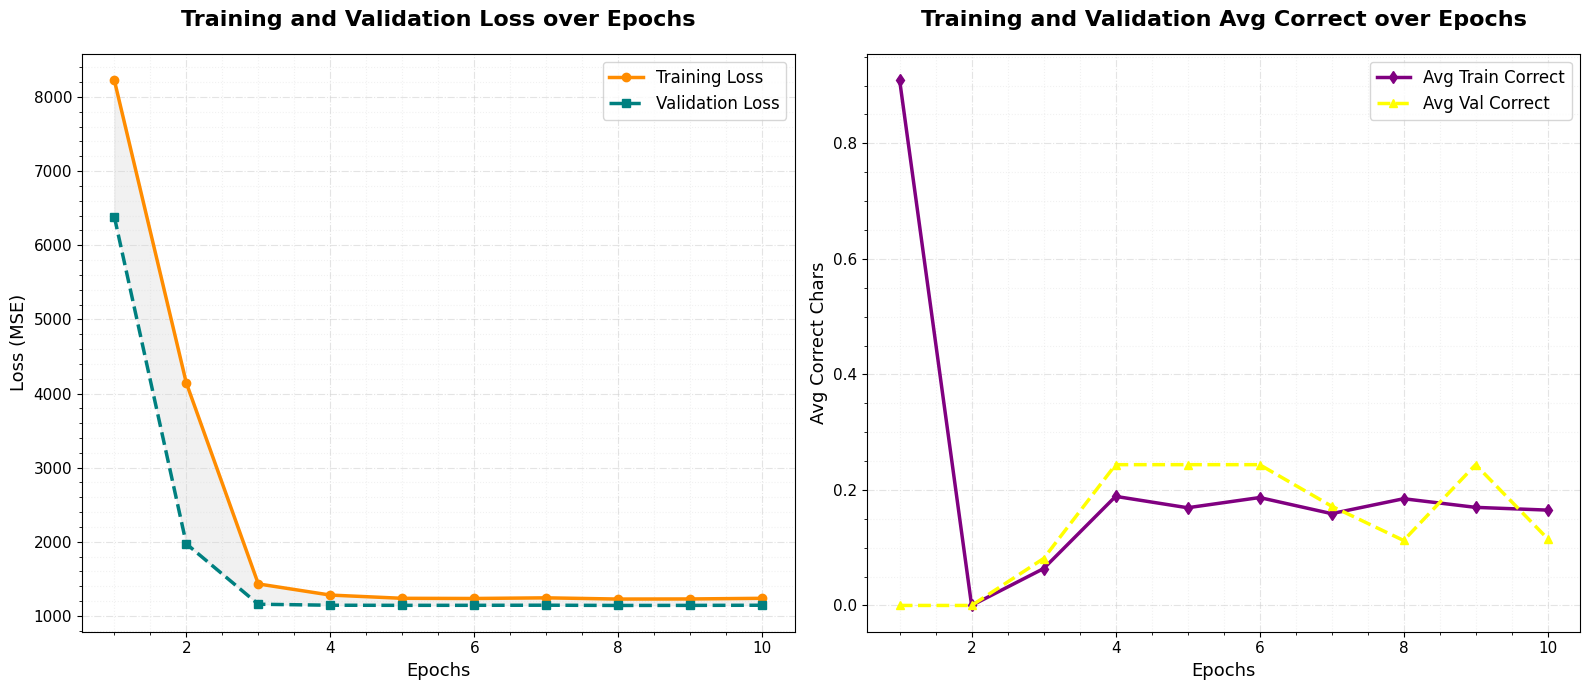

In [12]:
plot_loss_graph(train_loss_arr1, val_loss_arr1, train_correct_arr1, val_correct_arr1)

### Model 2

In [13]:
# Initialize the model
model2 = OCRModel(input_channels=hyperparams2["input_channels"], hidden_size=hyperparams2["hidden_size"], num_layers=hyperparams2["num_layers"], output_size=hyperparams2["output_size"], dropout=hyperparams2["dropout"])
model2.to(device)
model2.load_data(image_dir, train_image_names, val_image_names, hyperparams2["batch_size"])
print("Data loaded")

# Train the model
train_loss_arr2, val_loss_arr2, train_correct_arr2, val_correct_arr2 = model2.train_model(criterion="mse", optimiser="Adam", num_epochs=hyperparams2["num_epochs"], lr=hyperparams2["lr"], device=device)

# Testing the model
test_loss2, test_correct2 = model2.get_loss(image_dir, test_image_names)
print(f"Test Loss (MSE): {test_loss2:.4f}, Avg Test Correct: {test_correct2:.4f}")

Data loaded
Epoch 1/10, Train Loss (MSE): 8885.2815, Val Loss (MSE): 8195.7734, Avg Train Correct: 1.1352, Avg Val Correct: 0.0000
Epoch 2/10, Train Loss (MSE): 7417.7650, Val Loss (MSE): 6132.7783, Avg Train Correct: 0.0027, Avg Val Correct: 0.0000
Epoch 3/10, Train Loss (MSE): 5033.6693, Val Loss (MSE): 3660.6321, Avg Train Correct: 0.0000, Avg Val Correct: 0.0000
Epoch 4/10, Train Loss (MSE): 2822.7842, Val Loss (MSE): 1993.3378, Avg Train Correct: 0.0000, Avg Val Correct: 0.0000
Epoch 5/10, Train Loss (MSE): 1744.1230, Val Loss (MSE): 1344.8420, Avg Train Correct: 0.0129, Avg Val Correct: 0.0000
Epoch 6/10, Train Loss (MSE): 1376.2375, Val Loss (MSE): 1192.0353, Avg Train Correct: 0.1196, Avg Val Correct: 0.2594
Epoch 7/10, Train Loss (MSE): 1322.6574, Val Loss (MSE): 1156.0308, Avg Train Correct: 0.1386, Avg Val Correct: 0.2781
Epoch 8/10, Train Loss (MSE): 1297.1964, Val Loss (MSE): 1147.9141, Avg Train Correct: 0.1522, Avg Val Correct: 0.2844
Epoch 9/10, Train Loss (MSE): 1311.4

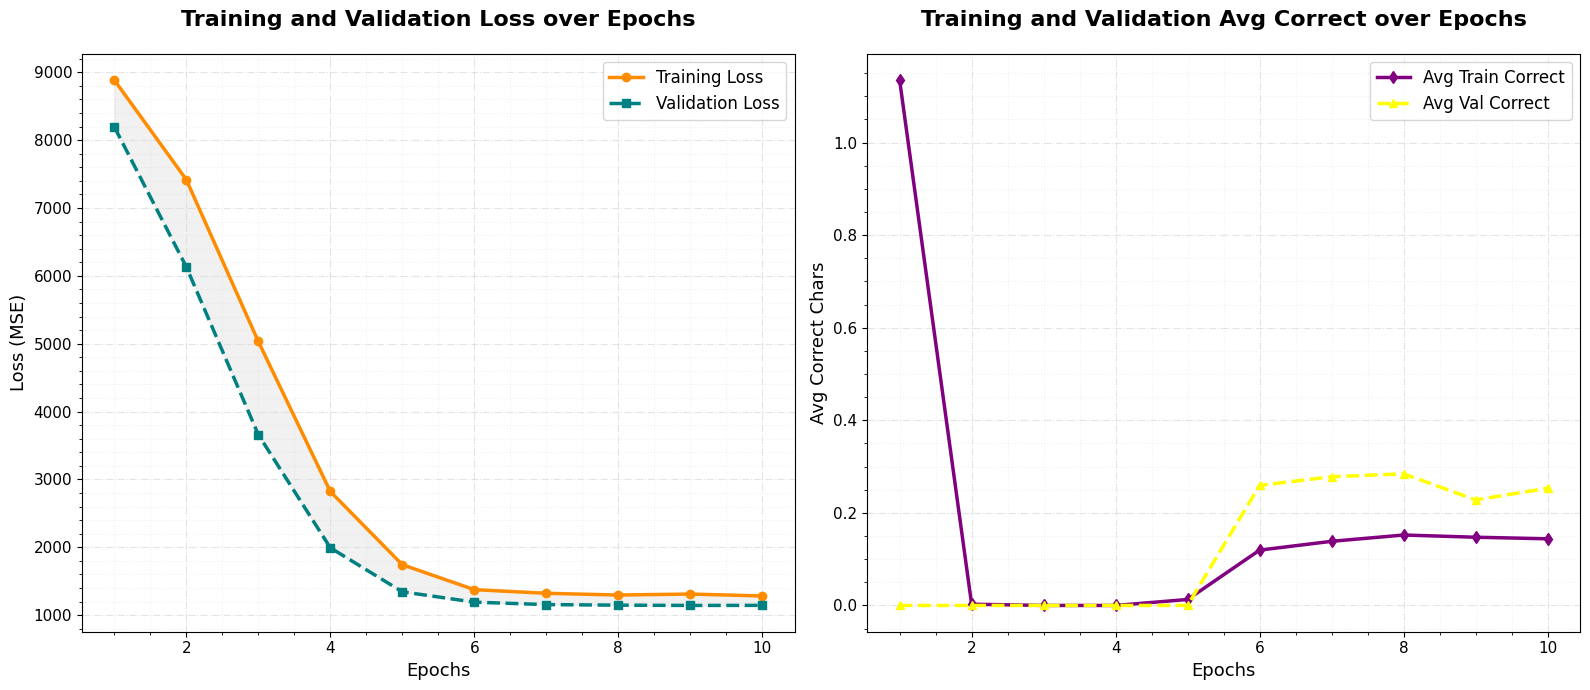

In [14]:
plot_loss_graph(train_loss_arr2, val_loss_arr2, train_correct_arr2, val_correct_arr2)

### Model 3

In [15]:
# Initialize the model
model3 = OCRModel(input_channels=hyperparams3["input_channels"], hidden_size=hyperparams3["hidden_size"], num_layers=hyperparams3["num_layers"], output_size=hyperparams3["output_size"], dropout=hyperparams3["dropout"])
model3.to(device)
model3.load_data(image_dir, train_image_names, val_image_names, hyperparams3["batch_size"])
print("Data loaded")

# Train the model
train_loss_arr3, val_loss_arr3, train_correct_arr3, val_correct_arr3 = model3.train_model(criterion="mse", optimiser="Adam", num_epochs=hyperparams3["num_epochs"], lr=hyperparams3["lr"], device=device)

# Testing the model
test_loss3, test_correct3 = model3.get_loss(image_dir, test_image_names)
print(f"Test Loss (MSE): {test_loss3:.4f}, Avg Test Correct: {test_correct3:.4f}")

Data loaded
Epoch 1/10, Train Loss (MSE): 2374.1195, Val Loss (MSE): 1236.5314, Avg Train Correct: 0.1522, Avg Val Correct: 0.2500
Epoch 2/10, Train Loss (MSE): 1355.0171, Val Loss (MSE): 1156.4330, Avg Train Correct: 0.1250, Avg Val Correct: 0.1531
Epoch 3/10, Train Loss (MSE): 1297.9228, Val Loss (MSE): 1304.6123, Avg Train Correct: 0.1583, Avg Val Correct: 0.0187
Epoch 4/10, Train Loss (MSE): 1328.5433, Val Loss (MSE): 1357.0875, Avg Train Correct: 0.1739, Avg Val Correct: 0.0000
Epoch 5/10, Train Loss (MSE): 1412.5524, Val Loss (MSE): 1241.0966, Avg Train Correct: 0.1148, Avg Val Correct: 0.2281
Epoch 6/10, Train Loss (MSE): 1465.6782, Val Loss (MSE): 1288.4228, Avg Train Correct: 0.1005, Avg Val Correct: 0.0000
Epoch 7/10, Train Loss (MSE): 1379.5462, Val Loss (MSE): 1381.5561, Avg Train Correct: 0.1230, Avg Val Correct: 0.2156
Epoch 8/10, Train Loss (MSE): 1418.6927, Val Loss (MSE): 1264.4739, Avg Train Correct: 0.1087, Avg Val Correct: 0.0781
Epoch 9/10, Train Loss (MSE): 1421.8

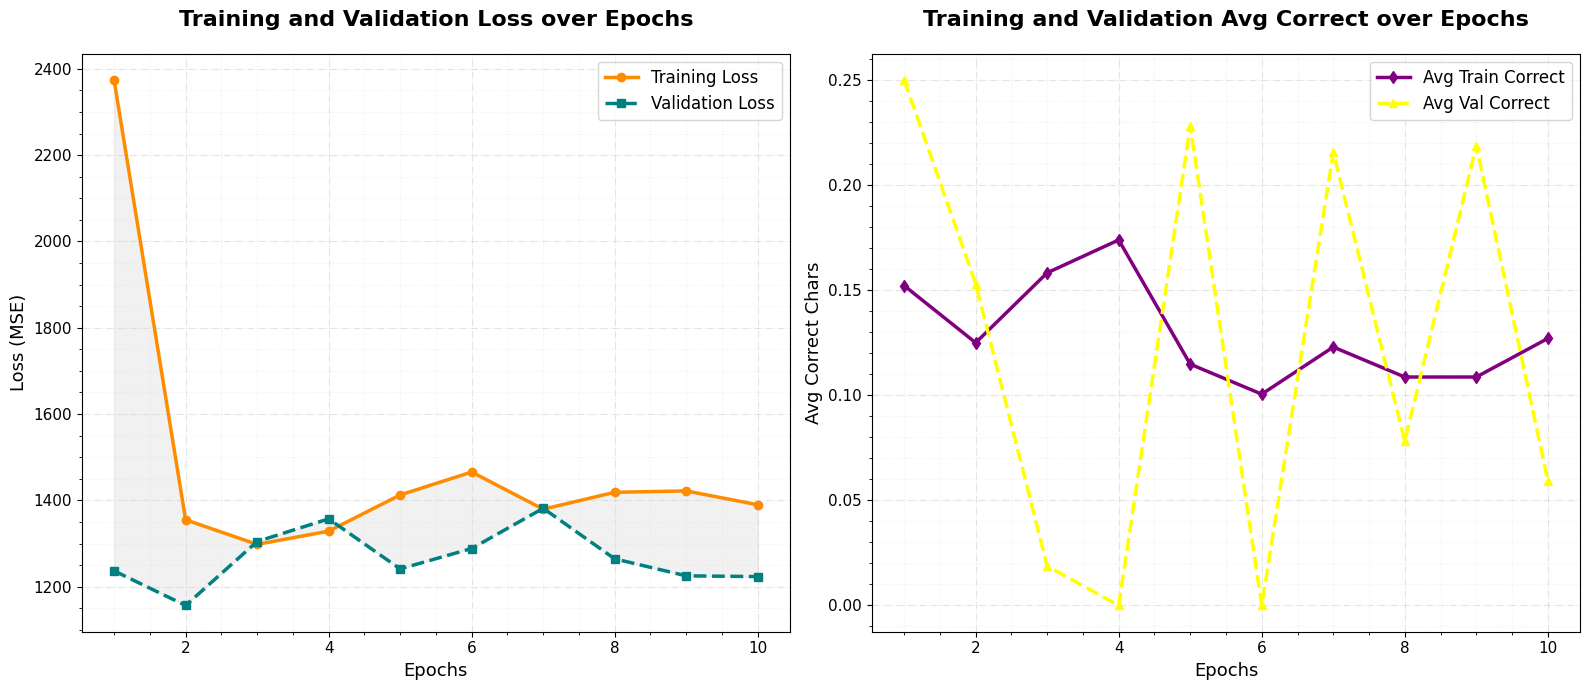

In [16]:
plot_loss_graph(train_loss_arr3, val_loss_arr3, train_correct_arr3, val_correct_arr3)

### Model 4

In [17]:
# Initialize the model
model4 = OCRModel(input_channels=hyperparams4["input_channels"], hidden_size=hyperparams4["hidden_size"], num_layers=hyperparams4["num_layers"], output_size=hyperparams4["output_size"], dropout=hyperparams4["dropout"])
model4.to(device)
model4.load_data(image_dir, train_image_names, val_image_names, hyperparams4["batch_size"])
print("Data loaded")

# Train the model
train_loss_arr4, val_loss_arr4, train_correct_arr4, val_correct_arr4 = model4.train_model(criterion="mse", optimiser="Adam", num_epochs=hyperparams4["num_epochs"], lr=hyperparams4["lr"], device=device)

# Testing the model
test_loss4, test_correct4 = model4.get_loss(image_dir, test_image_names)
print(f"Test Loss (MSE): {test_loss4:.4f}, Avg Test Correct: {test_correct4:.4f}")

Data loaded
Epoch 1/10, Train Loss (MSE): 7309.1986, Val Loss (MSE): 4094.2074, Avg Train Correct: 0.5231, Avg Val Correct: 0.0000
Epoch 2/10, Train Loss (MSE): 2034.5062, Val Loss (MSE): 1164.7423, Avg Train Correct: 0.0428, Avg Val Correct: 0.1562
Epoch 3/10, Train Loss (MSE): 1236.1701, Val Loss (MSE): 1142.3173, Avg Train Correct: 0.1889, Avg Val Correct: 0.1750
Epoch 4/10, Train Loss (MSE): 1229.6015, Val Loss (MSE): 1141.5758, Avg Train Correct: 0.1753, Avg Val Correct: 0.0938
Epoch 5/10, Train Loss (MSE): 1239.7528, Val Loss (MSE): 1141.4865, Avg Train Correct: 0.1664, Avg Val Correct: 0.0969
Epoch 6/10, Train Loss (MSE): 1233.2128, Val Loss (MSE): 1142.8857, Avg Train Correct: 0.1719, Avg Val Correct: 0.1500
Epoch 7/10, Train Loss (MSE): 1234.0624, Val Loss (MSE): 1140.3208, Avg Train Correct: 0.1760, Avg Val Correct: 0.1156
Epoch 8/10, Train Loss (MSE): 1234.4514, Val Loss (MSE): 1154.0053, Avg Train Correct: 0.1814, Avg Val Correct: 0.0906
Epoch 9/10, Train Loss (MSE): 1234.1

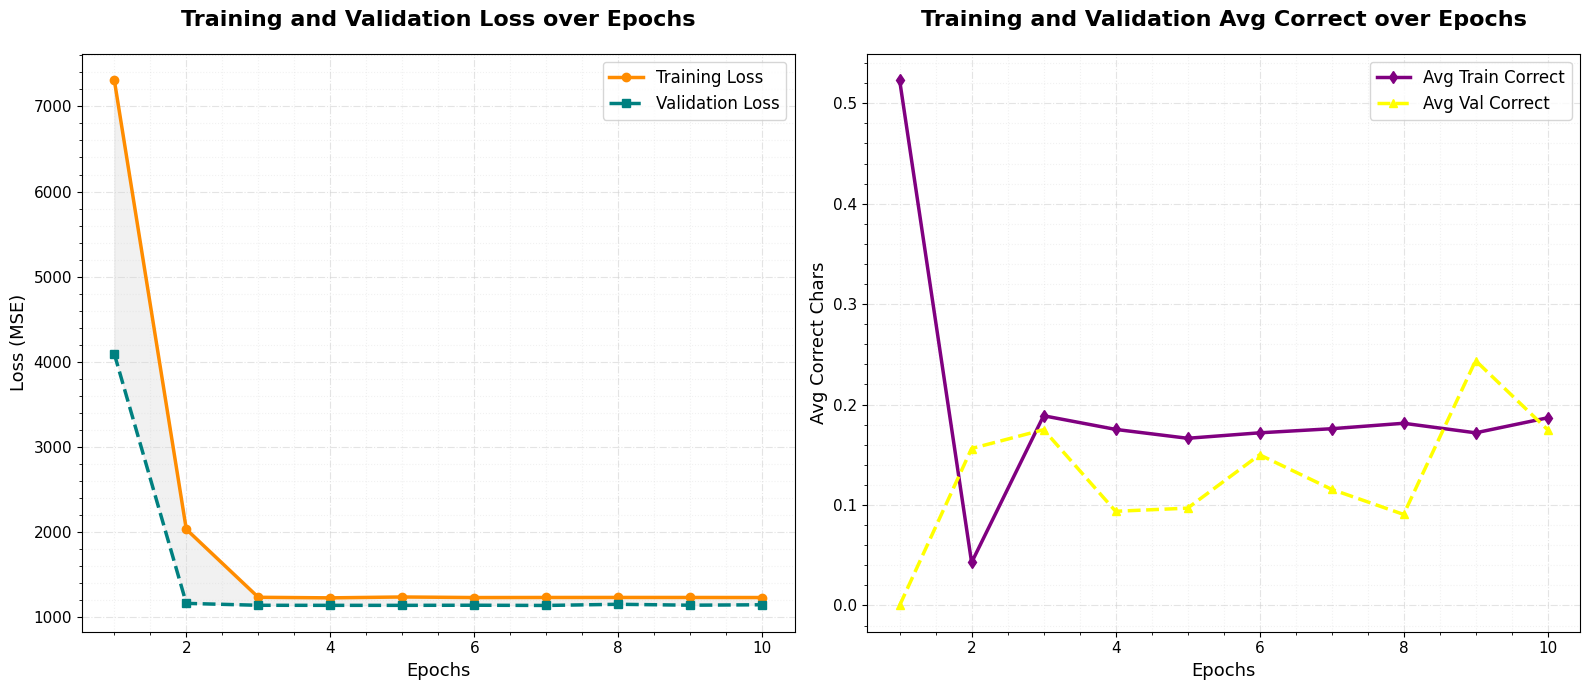

In [18]:
plot_loss_graph(train_loss_arr4, val_loss_arr4, train_correct_arr4, val_correct_arr4)

### Model 5

In [19]:
# Initialize the model
model5 = OCRModel(input_channels=hyperparams5["input_channels"], hidden_size=hyperparams5["hidden_size"], num_layers=hyperparams5["num_layers"], output_size=hyperparams5["output_size"], dropout=hyperparams5["dropout"])
model5.to(device)
model5.load_data(image_dir, train_image_names, val_image_names, hyperparams5["batch_size"])
print("Data loaded")

# Train the model
train_loss_arr5, val_loss_arr5, train_correct_arr5, val_correct_arr5 = model5.train_model(criterion="mse", optimiser="Adam", num_epochs=hyperparams5["num_epochs"], lr=hyperparams5["lr"], device=device)

# Testing the model
test_loss5, test_correct5 = model5.get_loss(image_dir, test_image_names)
print(f"Test Loss (MSE): {test_loss5:.4f}, Avg Test Correct: {test_correct5:.4f}")

Data loaded
Epoch 1/10, Train Loss (MSE): 8341.8131, Val Loss (MSE): 6647.6583, Avg Train Correct: 0.6875, Avg Val Correct: 0.0000
Epoch 2/10, Train Loss (MSE): 4515.6831, Val Loss (MSE): 2353.4367, Avg Train Correct: 0.0000, Avg Val Correct: 0.0000
Epoch 3/10, Train Loss (MSE): 1632.6140, Val Loss (MSE): 1185.4458, Avg Train Correct: 0.0394, Avg Val Correct: 0.2906
Epoch 4/10, Train Loss (MSE): 1263.1731, Val Loss (MSE): 1140.3736, Avg Train Correct: 0.1719, Avg Val Correct: 0.1344
Epoch 5/10, Train Loss (MSE): 1254.9594, Val Loss (MSE): 1142.3852, Avg Train Correct: 0.1814, Avg Val Correct: 0.1719
Epoch 6/10, Train Loss (MSE): 1248.0909, Val Loss (MSE): 1145.7630, Avg Train Correct: 0.1692, Avg Val Correct: 0.1719
Epoch 7/10, Train Loss (MSE): 1270.2497, Val Loss (MSE): 1142.3223, Avg Train Correct: 0.1692, Avg Val Correct: 0.2437
Epoch 8/10, Train Loss (MSE): 1258.9302, Val Loss (MSE): 1141.8890, Avg Train Correct: 0.1739, Avg Val Correct: 0.2437
Epoch 9/10, Train Loss (MSE): 1240.5

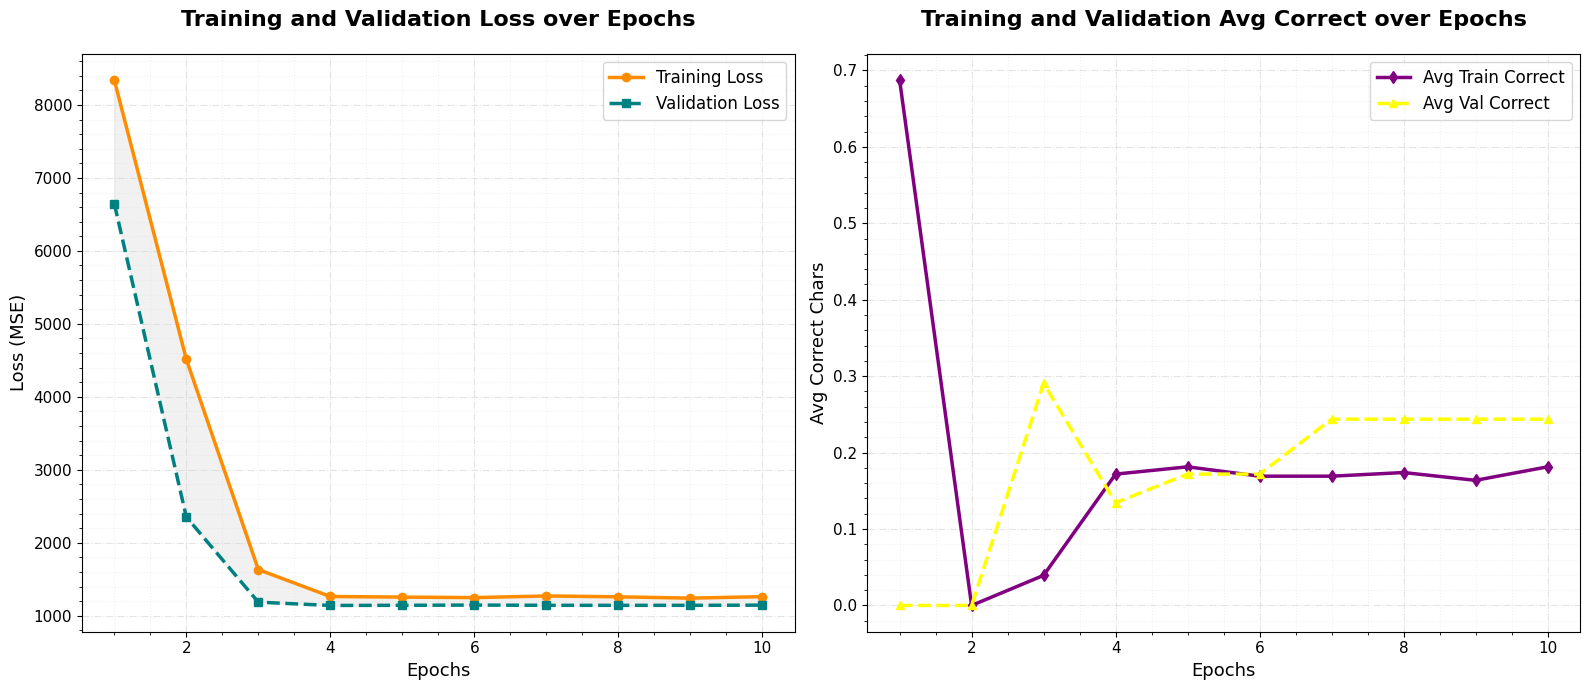

In [20]:
plot_loss_graph(train_loss_arr5, val_loss_arr5, train_correct_arr5, val_correct_arr5)

## Comparing with random baseline

In [22]:
n_correct_chars = 0

for i in range(len(test_image_names)):
    img_name = test_image_names[i]
    name = img_name.split("_")[1].split(".")[0].lower()
    int_chars = [ord(ch) for ch in name]
    rand_int_chars = np.random.randint(0, 128, len(int_chars))
    for j in range(len(int_chars)):
        if int_chars[j] == rand_int_chars[j]:
            n_correct_chars += 1

avg_correct_random = n_correct_chars / len(test_image_names)
print(f"Average correct characters in random baseline: {avg_correct_random}")

Average correct characters in random baseline: 0.0970873786407767
